# Customer Interactions



------------
Each line in the dataset contains a series of 15 previous interactions and a target interaction column:
* When clients are interacting with our system, typically they are on happy path but occasionally they deviate from it which may result in negative experience while impacting customer interactions, I would like to predict those negative experiences at any given time by checking past 15 customer interaction data points over 30 days, even if there is more, the set is restricted to most recent 15 actions.

The data source is customer interactions, each code represent an event, true nature of interctions is not described, though:
* I gathered such data and defined the data model what would need to look for, represented by columns as below, all features are numeric, as explained interactions are transformed into numerical codes.
* id is a unique identifier per row which bundles interactions together within the row
* prev_action_15 
through
* prev_action_1 columns
    * they contain previous interaction codes, from oldest to newest action code: prev_action_15 being oldest and prev_action_1 being most recent in the data model representation
    * If there are not enough data points in client interaction history, 0 will be placed in these previous action columns. Please note, semantically, zeros will start appearing from prev_action_15 (from oldest to newest). 0 cannot be on prev_action_1 which means no entry over 30 days for this client!
* action is the target column
* Sample data below:

|id	|prev_action_15	|prev_action_14	|prev_action_13	|prev_action_12	|prev_action_11	|prev_action_10	|prev_action_9	|prev_action_8	|prev_action_7	|prev_action_6	|prev_action_5	|prev_action_4	|prev_action_3	|prev_action_2	|prev_action_1	|action|
|---|---------------|---------------|---------------|---------------|---------------|---------------|-------------	|--------------|--------------|--------------|--------------|--------------|--------------|--------------|--------------|------|
|19059237|	104|	158|	131|	72|	179|	75|	75|	73|	180|	180|	179|	180|	75|	55|	75|	55|
|73879930|	0|	0|	0|	75|	77|	162|	75|	75|	75|	75|	75|	111|	111|	55|	75|	55|

Note to the second line entry, there are not enough entries, so, 3 0s in those columns. The data columns are filled with 0 if interaction is missing.


For the capstone project, I am using series of customer interactions to predict a couple target actions:
- 142 and
- 55

to be proactive about those negative outcomes. Data is customer interaction set, they are generated when customer is actively interacting with the system, so, there are no regular intervals. It is cleaned from the data source and are all masked and generalized to avoid revealing any sensitive information. True identity, action numbers are all masked and datetime are removed, they are not linked to any actual data whatsoever.


The techniques to use in analysis
* This first phase focus is binary classification, specifically the techniques I would like to utilize are `Logistic Regression` and `Decision Tree`.

The expected results
* The expected result is predicting action column in my dataset and also discover interaction patterns. In the initial phase, my approach will be two models to predict action code = `55` and `142` respectively. Optionally, the next phase will be a multi-class model to predict multi-class action code = `55` and/or `142` with probability as multinomial model but this is not a deal breaker.

Why this question is important
* This is a preliminary work in parallel to an ongoing work, I would like to apply the techniques I learnt, see if it helps in anyway to identify those patterns in the dataset, or any improvement point I could bring up comparing my results with the existing. A working classification model is highly desired here to compare its performance with the existing outcome.
 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# Exploratory Data Analysis
Data in the file is already cleaned up, no further procesing required.

In [39]:
# Read actions from excel sheet
xlsx = pd.ExcelFile('data/interactions_08052022.xlsx')
# Tab names for 2 set of samples 55 and 142
# 142
actions1 = pd.read_excel(xlsx, 'Sample H')
# 55
actions2 = pd.read_excel(xlsx, 'Sample A')

In [3]:
# start time
tstart = datetime.now()
print(tstart)

2022-09-24 06:58:35.207978


# Set #1

In [4]:
actions1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4048 entries, 0 to 4047
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              4048 non-null   int64
 1   prev_action_15  4048 non-null   int64
 2   prev_action_14  4048 non-null   int64
 3   prev_action_13  4048 non-null   int64
 4   prev_action_12  4048 non-null   int64
 5   prev_action_11  4048 non-null   int64
 6   prev_action_10  4048 non-null   int64
 7   prev_action_9   4048 non-null   int64
 8   prev_action_8   4048 non-null   int64
 9   prev_action_7   4048 non-null   int64
 10  prev_action_6   4048 non-null   int64
 11  prev_action_5   4048 non-null   int64
 12  prev_action_4   4048 non-null   int64
 13  prev_action_3   4048 non-null   int64
 14  prev_action_2   4048 non-null   int64
 15  prev_action_1   4048 non-null   int64
 16  action          4048 non-null   int64
dtypes: int64(17)
memory usage: 537.8 KB


In [5]:
# Replace all None with 0 in the dataset if any
#actions.replace('None', 0, inplace = True)

In [6]:
pd.options.display.max_columns = None

In [7]:
actions1

,id,prev_action_15,prev_action_14,prev_action_13,prev_action_12,prev_action_11,prev_action_10,prev_action_9,prev_action_8,prev_action_7,prev_action_6,prev_action_5,prev_action_4,prev_action_3,prev_action_2,prev_action_1,action
0,12711414,25,25,25,25,25,25,25,25,25,25,179,25,180,143,142,142
1,20635155,185,185,142,185,185,142,185,185,185,185,142,185,185,185,185,142
2,44789016,179,180,48,179,179,180,180,179,180,179,179,180,179,180,180,142
3,75610491,1,4,4,4,5,5,4,4,75,75,179,180,142,142,142,142
4,70030494,179,142,180,180,75,179,180,143,75,75,179,180,179,180,75,142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4043,84778540,0,0,0,0,0,0,0,0,0,0,76,76,76,76,76,76
4044,31998299,0,0,0,0,0,0,0,46,48,46,46,179,180,46,179,180
4045,79580262,0,0,0,0,0,0,0,75,158,48,179,180,46,46,179,180
4046,91488534,179,180,46,76,75,158,46,179,180,75,158,75,48,179,180,46


In [8]:
actions1.describe()

,id,prev_action_15,prev_action_14,prev_action_13,prev_action_12,prev_action_11,prev_action_10,prev_action_9,prev_action_8,prev_action_7,prev_action_6,prev_action_5,prev_action_4,prev_action_3,prev_action_2,prev_action_1,action
count,4.048000e+03,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000
mean,5.034346e+07,78.953557,81.502717,84.197134,86.343132,89.644516,92.356472,94.340662,97.752470,102.304842,103.166008,106.316206,113.518775,112.826087,112.386364,132.516798,130.677619
std,2.892457e+07,74.652261,74.868084,74.256514,73.748875,73.659290,73.240317,72.071964,71.637751,71.294376,69.462731,67.917025,66.641673,63.214168,61.339991,52.447121,41.474182
min,2.054000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,2.510344e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.000000,46.000000,46.000000,75.000000,75.000000,46.000000,76.000000,76.000000
50%,5.074918e+07,75.000000,75.000000,76.000000,77.000000,80.000000,110.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000
75%,7.540206e+07,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,142.000000
max,9.999633e+07,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,230.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000


# Set #2

In [9]:
actions2

,id,prev_action_15,prev_action_14,prev_action_13,prev_action_12,prev_action_11,prev_action_10,prev_action_9,prev_action_8,prev_action_7,prev_action_6,prev_action_5,prev_action_4,prev_action_3,prev_action_2,prev_action_1,action
0,1873817,68,179,73,180,68,179,68,68,180,75,179,180,179,180,75,55
1,6742635,72,75,179,180,75,75,75,75,75,75,179,180,76,76,75,55
2,53659561,105,75,75,75,105,105,46,183,183,179,180,46,183,183,179,180
3,86755049,104,46,105,104,46,105,104,111,111,46,56,56,56,105,104,55
4,45702739,105,104,111,111,55,105,104,111,111,55,105,104,55,105,104,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,56599632,184,183,179,184,180,75,75,75,75,46,183,184,183,179,184,180
14996,64127369,184,180,158,159,75,159,158,75,75,46,183,184,183,179,184,180
14997,54735655,184,183,179,184,180,46,183,183,179,184,180,179,180,77,75,55
14998,81904597,184,183,179,180,75,48,46,179,180,179,180,75,75,46,179,180


In [10]:
actions2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              15000 non-null  int64
 1   prev_action_15  15000 non-null  int64
 2   prev_action_14  15000 non-null  int64
 3   prev_action_13  15000 non-null  int64
 4   prev_action_12  15000 non-null  int64
 5   prev_action_11  15000 non-null  int64
 6   prev_action_10  15000 non-null  int64
 7   prev_action_9   15000 non-null  int64
 8   prev_action_8   15000 non-null  int64
 9   prev_action_7   15000 non-null  int64
 10  prev_action_6   15000 non-null  int64
 11  prev_action_5   15000 non-null  int64
 12  prev_action_4   15000 non-null  int64
 13  prev_action_3   15000 non-null  int64
 14  prev_action_2   15000 non-null  int64
 15  prev_action_1   15000 non-null  int64
 16  action          15000 non-null  int64
dtypes: int64(17)
memory usage: 1.9 MB


In [11]:
actions2.describe()

,id,prev_action_15,prev_action_14,prev_action_13,prev_action_12,prev_action_11,prev_action_10,prev_action_9,prev_action_8,prev_action_7,prev_action_6,prev_action_5,prev_action_4,prev_action_3,prev_action_2,prev_action_1,action
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,5.017598e+07,59.002067,60.158200,63.041200,64.838200,65.712000,69.223867,71.617400,71.868200,75.712067,77.634333,89.195933,98.256467,94.400533,96.421533,115.547533,93.516667
std,2.894509e+07,72.105794,71.911283,73.000656,73.120491,72.201368,73.157396,72.541931,71.559497,72.083380,70.571241,65.490695,65.151531,62.040644,60.599346,59.819464,55.841602
min,7.138000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.516904e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,46.000000,55.000000,48.000000,46.000000,75.000000,55.000000
50%,5.024182e+07,0.000000,41.000000,46.000000,46.000000,46.000000,48.000000,55.000000,55.000000,75.000000,75.000000,76.000000,80.000000,76.000000,77.000000,104.000000,55.000000
75%,7.546675e+07,101.000000,103.000000,111.000000,158.000000,131.000000,162.000000,179.000000,159.000000,179.000000,179.000000,179.000000,179.000000,179.000000,158.000000,179.000000,180.000000
max,9.999584e+07,220.000000,229.000000,229.000000,219.000000,234.000000,229.000000,230.000000,220.000000,230.000000,230.000000,219.000000,230.000000,229.000000,230.000000,220.000000,220.000000


# Dataset prep

In [12]:
#  event -> 142 to 1, rest to 0 if dataset is 1
#  event -> 55 to 1, rest to 0 if dataset is 2
def process_set(dataset):
    # prepare global dataset and return
    df = globals()['actions' + str(dataset)]
    # assign 0/1 for the event (by the chosen dataset) we are targeting:
    if dataset == 1:
        action = 142
    else:
        action = 55

    # Transform target column to 0/1 for yes/no
    # prepare target column as 1/0
    df.loc[df['action'] != action, 'action'] = 0
    df.loc[df['action'] == action, 'action'] = 1
    df['action'] = df['action'].astype('int64')

    return df

# Multicollinearity Check

In [13]:
# Variance Inflation Factor (VIF)
# multicollinearity if any feature 5+
def vif(data):
    columns = data.columns
    vif_dict = {}

    for col in data.select_dtypes(include=np.number).columns:
        exclude_col = [i for i in columns if i != col]
        X, y = data[exclude_col], data[col]

        features = data.select_dtypes(exclude=np.number).columns
        features = [c for c in data.select_dtypes(exclude=np.number).columns if c in data.columns]
        # fit model with set
        ridge = Ridge(alpha = 1)
        # vif = 1 / (1- R^2)
        r_squared = ridge.fit(X, y).score(X, y)
        if r_squared == 1:
            vif = 0
        else:
            vif = 1 / (1-r_squared)
        vif_dict[col] = vif

    df_vif = pd.DataFrame({"VIF":vif_dict}).sort_values(by = "VIF", ascending = False)
    return df_vif

# Feature Importance

In [14]:
# permutation importance
# function to execute permutation importance!
# returns a dataset "Column" and "Importance"
def column_importance(model):
    # fitted model with training set
    print('model r^2 :', model.score(X_test, y_test))
    # permutation importance
    r = permutation_importance(model, X_test, y_test, n_repeats = 50, random_state = 93)
    print('importance:', r.importances_mean)
    return pd.DataFrame({"Column":X.columns, "Importance":r.importances_mean}).sort_values(
        by = "Importance", ascending = False)

## Data Cleanup and Transformation
No cleanup needed. However, row cleanup may be needed, for example, any account do not have more than or equal to previous 5 records history will be removed after exploring the datasets!

### Data Transformation
```
 event -> 142 to 1, rest to 0 for action1
 event -> 55 to 1, rest to 0 for action2
```

# Set Dataset #1 to Process

In [40]:
# Copy dataset either 1 or 2
data_set = 1
act = process_set(data_set)

In [41]:
act.describe()

,id,prev_action_15,prev_action_14,prev_action_13,prev_action_12,prev_action_11,prev_action_10,prev_action_9,prev_action_8,prev_action_7,prev_action_6,prev_action_5,prev_action_4,prev_action_3,prev_action_2,prev_action_1,action
count,4.048000e+03,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000,4048.000000
mean,5.034346e+07,78.953557,81.502717,84.197134,86.343132,89.644516,92.356472,94.340662,97.752470,102.304842,103.166008,106.316206,113.518775,112.826087,112.386364,132.516798,0.500000
std,2.892457e+07,74.652261,74.868084,74.256514,73.748875,73.659290,73.240317,72.071964,71.637751,71.294376,69.462731,67.917025,66.641673,63.214168,61.339991,52.447121,0.500062
min,2.054000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.510344e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.000000,46.000000,46.000000,75.000000,75.000000,46.000000,76.000000,0.000000
50%,5.074918e+07,75.000000,75.000000,76.000000,77.000000,80.000000,110.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,0.500000
75%,7.540206e+07,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,179.000000,1.000000
max,9.999633e+07,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,230.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,229.000000,1.000000


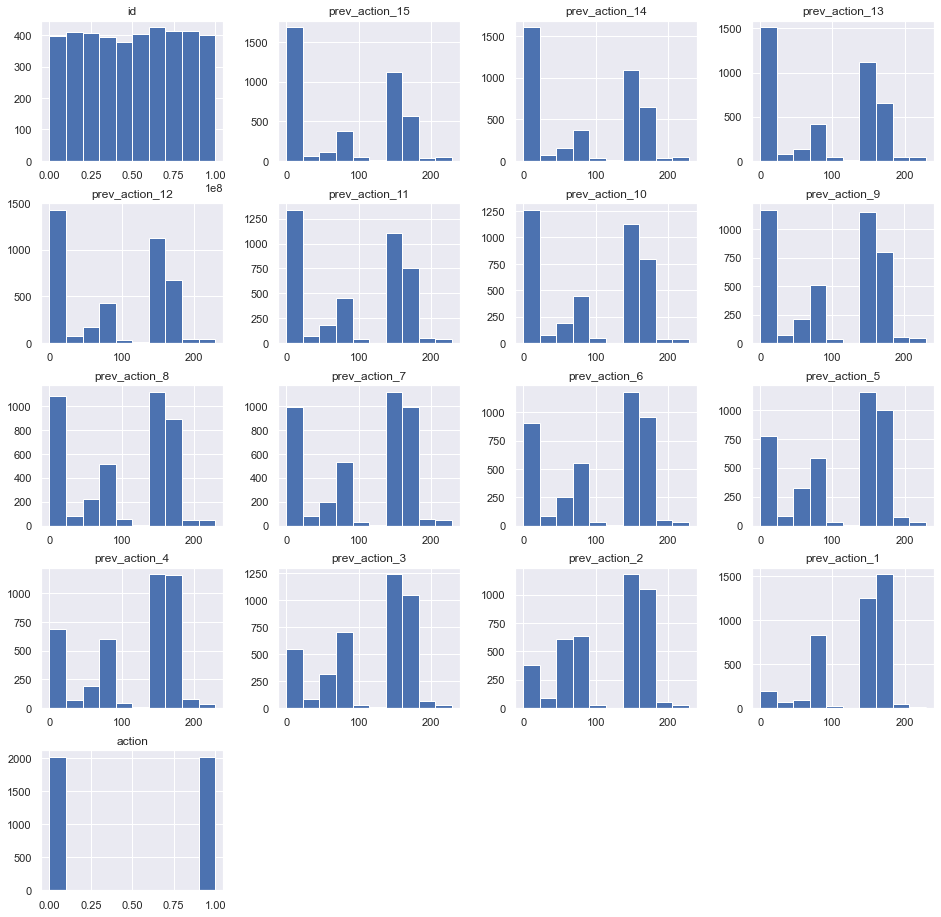

CPU times: user 1.55 s, sys: 9.93 ms, total: 1.56 s
Wall time: 1.56 s


In [42]:
%%time
# histograms
act.hist(figsize = (16, 16))
plt.show()

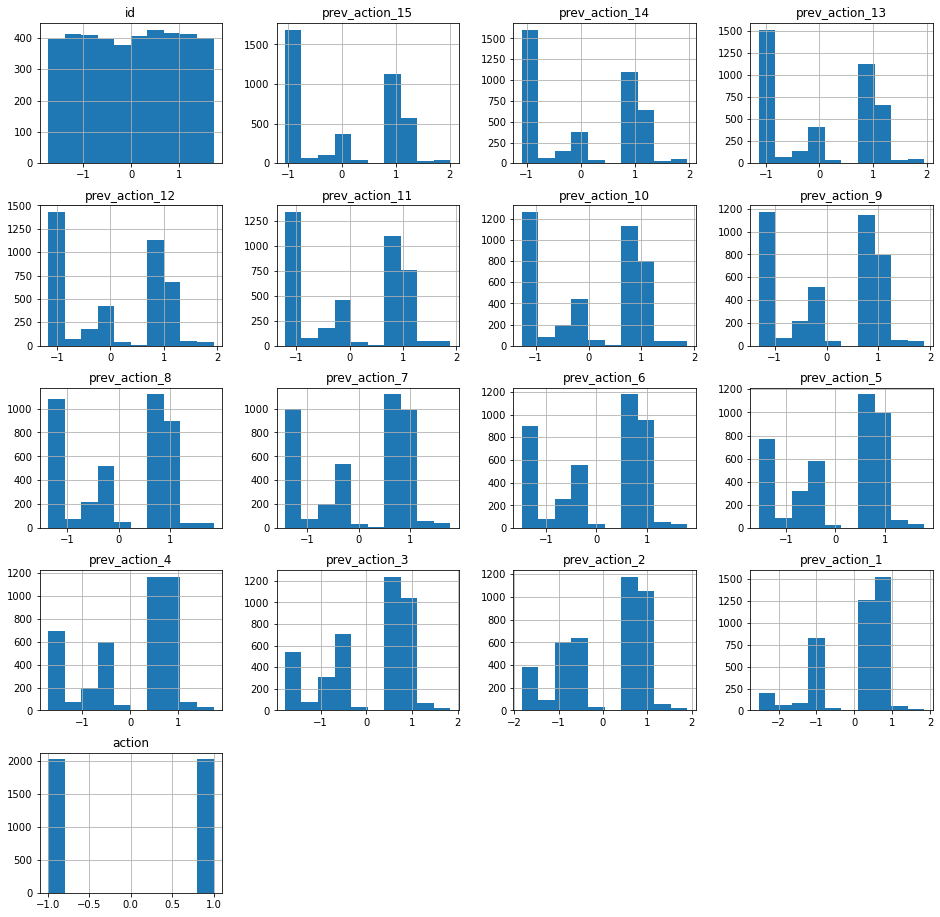

CPU times: user 1.31 s, sys: 14.4 ms, total: 1.33 s
Wall time: 1.33 s


In [18]:
%%time
# scale
scaler = StandardScaler()
act_scaled = scaler.fit_transform(act)
act_scaled = pd.DataFrame(act_scaled, columns=act.columns, index=act.index)

# histograms
act_scaled.hist(figsize = (16, 16))
plt.show()

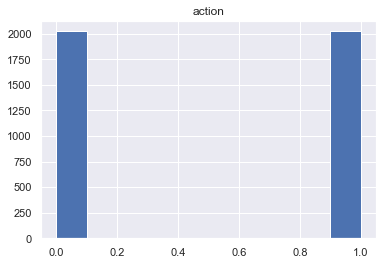

CPU times: user 127 ms, sys: 3.57 ms, total: 131 ms
Wall time: 129 ms


In [43]:
%%time
act[['action']].hist()
plt.show()

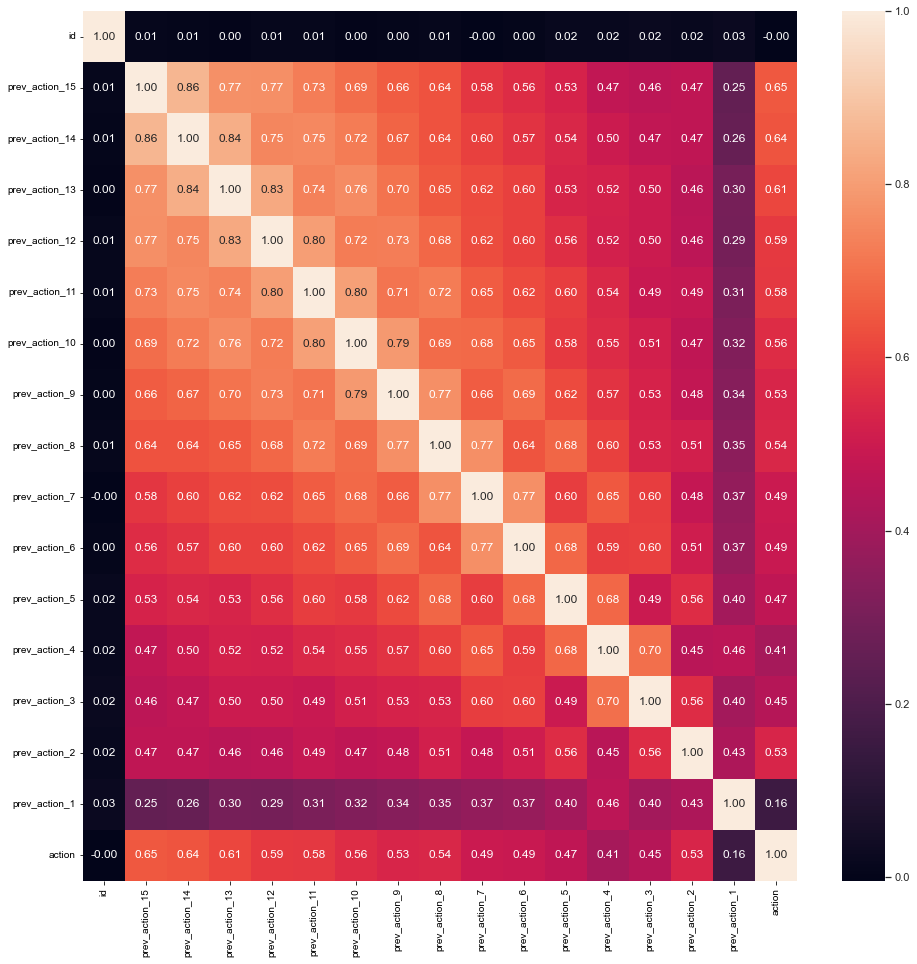

CPU times: user 782 ms, sys: 51.7 ms, total: 834 ms
Wall time: 831 ms


In [20]:
%%time
#heatmap
plt.subplots(figsize=(16,16))
sns.set(font_scale=1.0)
sns.heatmap(act.corr(), annot=True, fmt='.2f')
plt.show()

In [21]:
# separate independent variable - features - from target
#X, y = act.drop(['id', 'action'], axis = 1), act['action']
vif(act.drop(['id', 'action'], axis = 1))

,VIF
prev_action_14,6.003887
prev_action_13,5.455881
prev_action_12,4.897471
prev_action_11,4.616364
prev_action_15,4.582882
prev_action_10,4.519793
prev_action_8,4.287909
prev_action_9,4.148637
prev_action_7,4.111934
prev_action_6,3.565778


In [22]:
%%time
# separate independent variable - features - from target and split training and test datasets
X, y = act.drop(['id', 'action'], axis = 1), act['action']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 93, stratify = y)

lr = LogisticRegression().fit(X_train, y_train)
fi = column_importance(lr)
fi

model r^2 : 0.8715415019762845
importance: [0.03359684 0.01381423 0.01003953 0.00146245 0.00697628 0.00108696
 0.00086957 0.00104743 0.         0.00351779 0.0022332  0.00195652
 0.00594862 0.08456522 0.02555336]
CPU times: user 2.56 s, sys: 16.4 ms, total: 2.58 s
Wall time: 989 ms


,Column,Importance
13,prev_action_2,0.084565
0,prev_action_15,0.033597
14,prev_action_1,0.025553
1,prev_action_14,0.013814
2,prev_action_13,0.010040
4,prev_action_11,0.006976
12,prev_action_3,0.005949
9,prev_action_6,0.003518
10,prev_action_5,0.002233
11,prev_action_4,0.001957


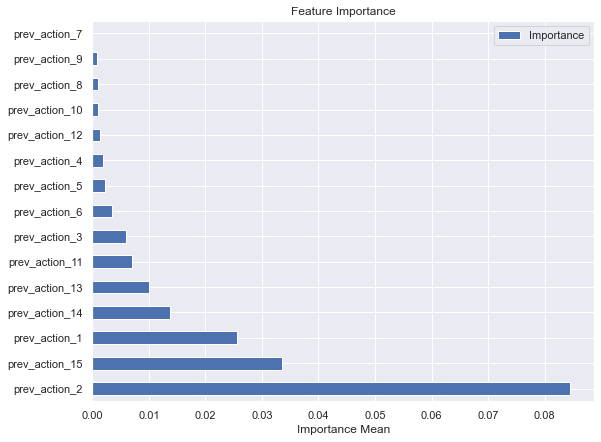

In [23]:
fi.plot.barh(figsize=(9, 7))
plt.title('Feature Importance')
plt.xlabel('Importance Mean')
plt.axvline(x=0, color='.5')
#plt.subplots_adjust(left=0.3)
#plt.yticks(ticks=fi.index, labels=fi['Column'])
plt.yticks(ticks=fi.reset_index().sort_values(by='index')['Column'].index,
            labels=fi.reset_index().sort_values(by='index')['Column'])
plt.show()

In [24]:
act

,id,prev_action_15,prev_action_14,prev_action_13,prev_action_12,prev_action_11,prev_action_10,prev_action_9,prev_action_8,prev_action_7,prev_action_6,prev_action_5,prev_action_4,prev_action_3,prev_action_2,prev_action_1,action
0,12711414,25,25,25,25,25,25,25,25,25,25,179,25,180,143,142,1
1,20635155,185,185,142,185,185,142,185,185,185,185,142,185,185,185,185,1
2,44789016,179,180,48,179,179,180,180,179,180,179,179,180,179,180,180,1
3,75610491,1,4,4,4,5,5,4,4,75,75,179,180,142,142,142,1
4,70030494,179,142,180,180,75,179,180,143,75,75,179,180,179,180,75,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4043,84778540,0,0,0,0,0,0,0,0,0,0,76,76,76,76,76,0
4044,31998299,0,0,0,0,0,0,0,46,48,46,46,179,180,46,179,0
4045,79580262,0,0,0,0,0,0,0,75,158,48,179,180,46,46,179,0
4046,91488534,179,180,46,76,75,158,46,179,180,75,158,75,48,179,180,0


In [25]:
act.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4048 entries, 0 to 4047
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              4048 non-null   int64
 1   prev_action_15  4048 non-null   int64
 2   prev_action_14  4048 non-null   int64
 3   prev_action_13  4048 non-null   int64
 4   prev_action_12  4048 non-null   int64
 5   prev_action_11  4048 non-null   int64
 6   prev_action_10  4048 non-null   int64
 7   prev_action_9   4048 non-null   int64
 8   prev_action_8   4048 non-null   int64
 9   prev_action_7   4048 non-null   int64
 10  prev_action_6   4048 non-null   int64
 11  prev_action_5   4048 non-null   int64
 12  prev_action_4   4048 non-null   int64
 13  prev_action_3   4048 non-null   int64
 14  prev_action_2   4048 non-null   int64
 15  prev_action_1   4048 non-null   int64
 16  action          4048 non-null   int64
dtypes: int64(17)
memory usage: 537.8 KB


No further cleaning is needed on the dataset, ready!

# Set Dataset #2 to Process

In [26]:
# Copy dataset either 1 or 2
data_set = 2
act = process_set(data_set)

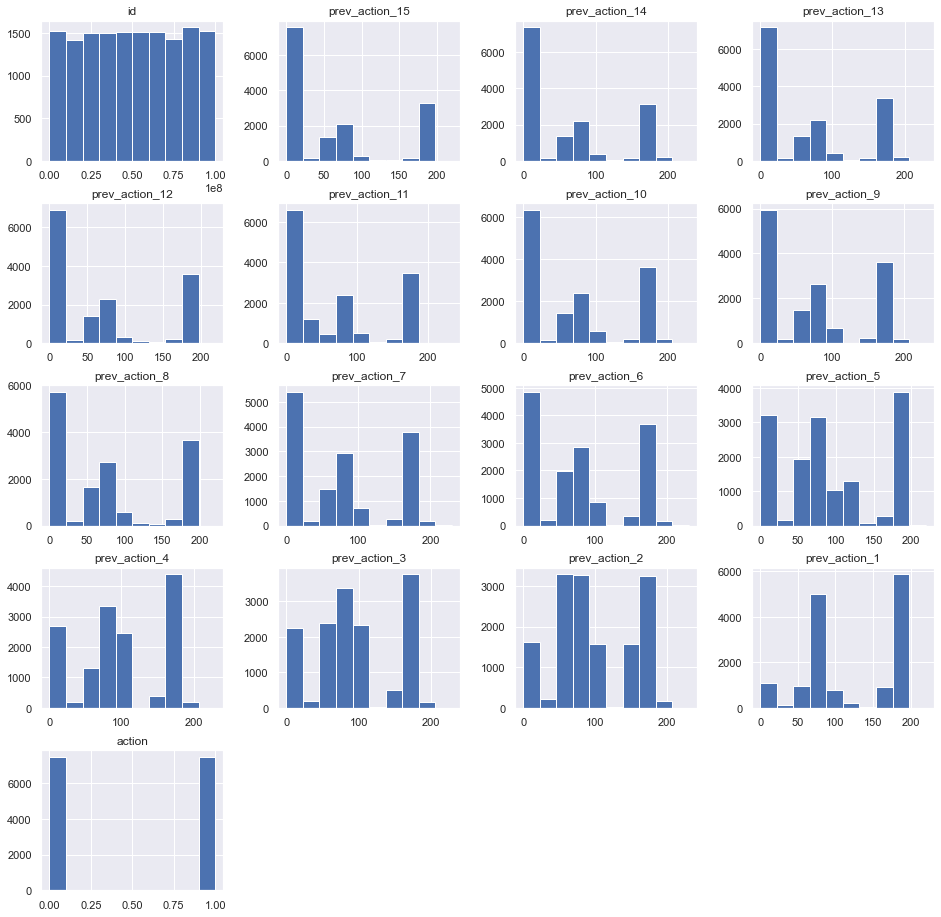

CPU times: user 1.49 s, sys: 12 ms, total: 1.5 s
Wall time: 1.5 s


In [27]:
%%time
# histograms
act.hist(figsize = (16, 16))
plt.show()

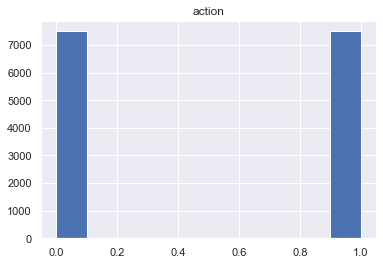

CPU times: user 196 ms, sys: 4.35 ms, total: 200 ms
Wall time: 198 ms


In [28]:
%%time
act[['action']].hist()
plt.show()

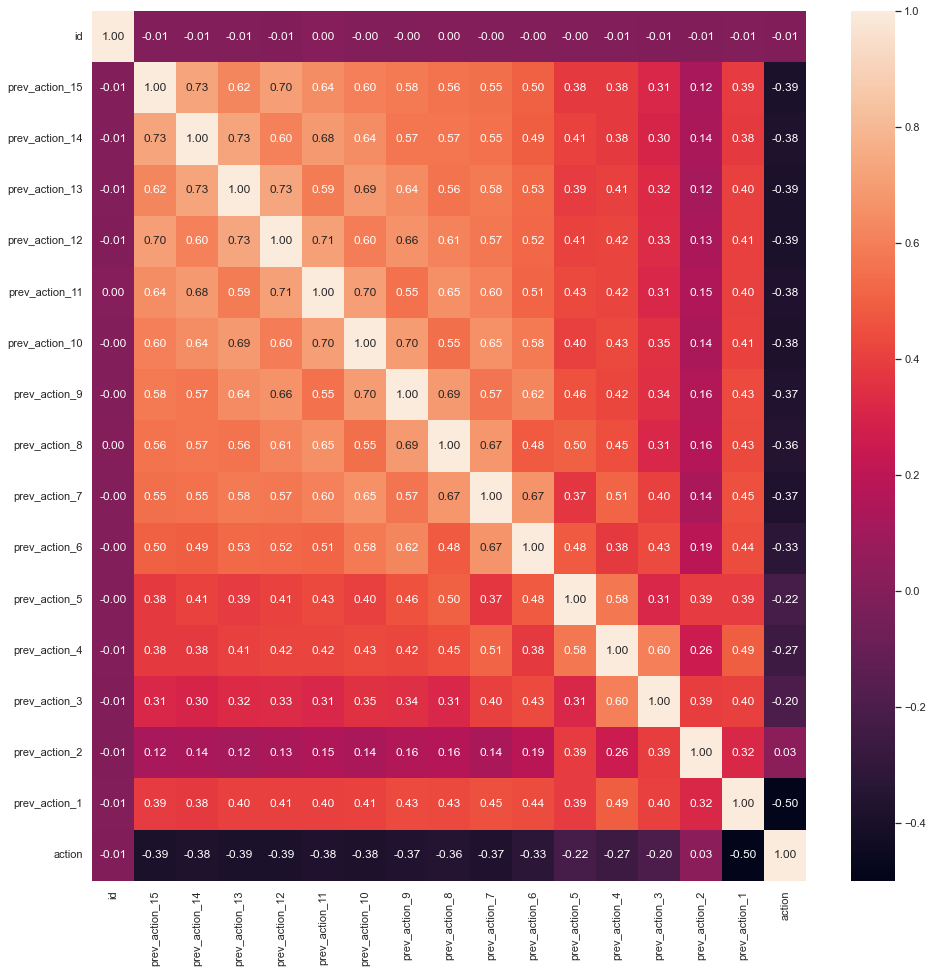

CPU times: user 811 ms, sys: 52.3 ms, total: 863 ms
Wall time: 861 ms


In [29]:
%%time
#heatmap
plt.subplots(figsize=(16,16))
sns.set(font_scale=1.0)
sns.heatmap(act.corr(), annot=True, fmt='.2f')
plt.show()

In [30]:
# separate independent variable - features - from target
#X, y = act.drop(['id', 'action'], axis = 1), act['action']
vif(act.drop(['id', 'action'], axis = 1))

,VIF
prev_action_12,3.943847
prev_action_10,3.752446
prev_action_11,3.745441
prev_action_13,3.629472
prev_action_9,3.584227
prev_action_14,3.466809
prev_action_7,3.466056
prev_action_8,3.385842
prev_action_15,2.893114
prev_action_6,2.831335


In [31]:
%%time
# separate independent variable - features - from target and split training and test datasets
X, y = act.drop(['id', 'action'], axis = 1), act['action']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 93, stratify = y)

lr = LogisticRegression().fit(X_train, y_train)
fi = column_importance(lr)
fi

model r^2 : 0.7554666666666666
importance: [-0.00331733 -0.00189867 -0.002368   -0.00288533 -0.00250667 -0.00024533
  0.00139733  0.00024    -0.00184533  0.00129067  0.000544   -0.00637867
  0.004944    0.00791467  0.15026667]
CPU times: user 10.7 s, sys: 83.3 ms, total: 10.8 s
Wall time: 1.35 s


,Column,Importance
14,prev_action_1,0.150267
13,prev_action_2,0.007915
12,prev_action_3,0.004944
6,prev_action_9,0.001397
9,prev_action_6,0.001291
10,prev_action_5,0.000544
7,prev_action_8,0.000240
5,prev_action_10,-0.000245
8,prev_action_7,-0.001845
1,prev_action_14,-0.001899


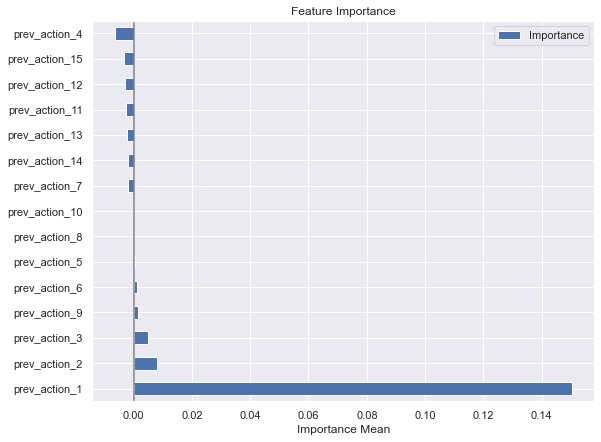

In [32]:
fi.plot.barh(figsize=(9, 7))
plt.title('Feature Importance')
plt.xlabel('Importance Mean')
plt.axvline(x=0, color='.5')
#plt.subplots_adjust(left=0.3)
#plt.yticks(ticks=fi.index, labels=fi['Column'])
plt.yticks(ticks=fi.reset_index().sort_values(by='index')['Column'].index,
            labels=fi.reset_index().sort_values(by='index')['Column'])
plt.show()

In [33]:
act

,id,prev_action_15,prev_action_14,prev_action_13,prev_action_12,prev_action_11,prev_action_10,prev_action_9,prev_action_8,prev_action_7,prev_action_6,prev_action_5,prev_action_4,prev_action_3,prev_action_2,prev_action_1,action
0,1873817,68,179,73,180,68,179,68,68,180,75,179,180,179,180,75,1
1,6742635,72,75,179,180,75,75,75,75,75,75,179,180,76,76,75,1
2,53659561,105,75,75,75,105,105,46,183,183,179,180,46,183,183,179,0
3,86755049,104,46,105,104,46,105,104,111,111,46,56,56,56,105,104,1
4,45702739,105,104,111,111,55,105,104,111,111,55,105,104,55,105,104,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,56599632,184,183,179,184,180,75,75,75,75,46,183,184,183,179,184,0
14996,64127369,184,180,158,159,75,159,158,75,75,46,183,184,183,179,184,0
14997,54735655,184,183,179,184,180,46,183,183,179,184,180,179,180,77,75,1
14998,81904597,184,183,179,180,75,48,46,179,180,179,180,75,75,46,179,0


In [34]:
act.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              15000 non-null  int64
 1   prev_action_15  15000 non-null  int64
 2   prev_action_14  15000 non-null  int64
 3   prev_action_13  15000 non-null  int64
 4   prev_action_12  15000 non-null  int64
 5   prev_action_11  15000 non-null  int64
 6   prev_action_10  15000 non-null  int64
 7   prev_action_9   15000 non-null  int64
 8   prev_action_8   15000 non-null  int64
 9   prev_action_7   15000 non-null  int64
 10  prev_action_6   15000 non-null  int64
 11  prev_action_5   15000 non-null  int64
 12  prev_action_4   15000 non-null  int64
 13  prev_action_3   15000 non-null  int64
 14  prev_action_2   15000 non-null  int64
 15  prev_action_1   15000 non-null  int64
 16  action          15000 non-null  int64
dtypes: int64(17)
memory usage: 1.9 MB
